### Brightness Distributions
This code calculates and plots the distribution of satellite brightness over the night sky, as seen by a ground-based observer. Several models are included.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import lumos.conversions
import lumos.brdf.library
import lumos.calculator
import lumos.plot
from starlink import satellitemodels
from lumos.brdf.library import BINOMIAL, LAMBERTIAN, PHONG
from lumos.geometry import Surface
from analysis import calculator
import matplotlib
import matplotlib.pyplot as plt



# Setting up the satellite model surfaces and earth_brdf.
surfaces = satellitemodels.get_surfaces()
earth_brdf = lumos.brdf.library.PHONG(Kd = 0.2, Ks = 0.2, n=300)


# Solar array BRDF parameters
B = np.array([[0.534, -20.409]])
C = np.array([[-527.765, 1000., -676.579, 430.596, -175.806, 57.879]])
lab_solar_array_brdf = BINOMIAL(B, C, d=3.0, l1=-3)

# Define solar array areas and their power equivalents
solar_array_configs = [
    (104.96 * 4, "~100 kW"),
    (104.96 * 5, "~125 kW"),
    (104.96 * 6, "~150 kW"),
    (104.96 * 7, "~175 kW"),
    (104.96 * 8, "~200 kW")
]


/Users/nayanjangid/Starlink_data center
Using interpolated chassis


In [2]:
altitudes = np.linspace(0, 90, 45)
azimuths = np.linspace(0, 360, 90)
altitudes, azimuths = np.meshgrid(altitudes, azimuths)

sun_azimuth = 90

In [3]:
# The following functions were made by Forrest Fankhauser. I have made minor changes to them
# and reimplimented them here.

def colorbar(cax, levels):
    cmap = matplotlib.colormaps['plasma_r']
    norm = matplotlib.colors.Normalize(levels[0], levels[1])
    cb = plt.colorbar(matplotlib.cm.ScalarMappable(
        norm=norm, cmap=cmap), cax=cax, extend='both')
    cb.set_ticks(np.arange(levels[0], levels[1] + 1, 3))   # 3,4,5,...,10

    cax.set_aspect(2)


def plot_compass(ax):
    ax.arrow(0, 0, 0, 0.75, width=0.05, color="black",
             head_length=0.2, head_width=0.2)
    ax.arrow(0, 0, -0.75, 0, width=0.05, color="black",
             head_length=0.2, head_width=0.2)
    ax.scatter([0], [0], s=30, c="black", zorder=1)
    ax.annotate("N", (0, 1.15), horizontalalignment='center',
                verticalalignment='center', fontsize=14, annotation_clip=False,
                fontweight='bold')
    ax.annotate("E", (-1.15, 0), horizontalalignment='center',
                verticalalignment='center', fontsize=14, annotation_clip=False,
                fontweight='bold')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim((-1.5, 0.5))
    ax.set_ylim((-0.5, 1.5))
    ax.set_frame_on(False)
    ax.set_aspect("equal")


def contour_observer_frame(
        ax,
        altitudes,
        azimuths,
        values,
        levels=None,
        cmap='plasma'
):
    """
    Creates contour plot in observer frame

    :param ax: Matplotlib axis for plotting on
    :type ax: :class:`matplotlib.pyplot.axes`
    :param altitudes: Altitudes in HCS frame (degrees)
    :type altitudes: :class:`np.ndarray`
    :param azimuths: Azimuths in HCS frame (degrees)
    :type azimuths: :class:`np.ndarray`
    :param values: Values to plot
    :type values: :class:`np.ndarray`
    :param levels: Minimum and maximum value to plot
    :type levels: tuple, optional
    :param cmap: Matplotlib colormap to use
    :type cmap: str
    """

    if levels is None:
        levels = (4, 10)

    ax.contourf(
        np.deg2rad(azimuths),
        90 - altitudes,
        values,
        cmap=matplotlib.colormaps[cmap],
        norm=matplotlib.colors.Normalize(levels[0], levels[1]),
        levels=np.arange(levels[0], levels[1] + 2, 0.25),
        extend='both'
    )

    ax.set_rmax(90)
    ax.set_yticklabels([])
    ax.set_theta_zero_location('N')
    ax.set_rticks([10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax.set_xticks(np.deg2rad([0, 90, 180, 270]))
    ax.set_xticklabels(['N', 'E', 'S', 'W'])
    ax.set_rlabel_position(-22.5)
    ax.grid(True)


def brightness_summary_observer_frame(
        sat_height, sun_altitudes, sun_azimuths,
        include_sun=True, include_earthshine=False,
        earth_panel_density=151, earth_brdf=earth_brdf,
        levels=(4, 10), name=None):
    if name is None:
        name = f"Starlink data center at {sat_height/1000:.0f} km elevation"

    N_frames = len(sun_altitudes)

    with plt.style.context("fast"):
        fig = plt.figure(figsize=(6.4 * 2, 3.2))
        fig.suptitle(name)

        cax = fig.add_axes([0, 0.25, 0.15, 0.3])

        h = 0.8
        w = h * 6 / 32

        ax1 = fig.add_axes([0.5 - w / 2 - 2 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax2 = fig.add_axes([0.5 - w / 2 - 1 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax3 = fig.add_axes([0.5 - w / 2 + 0 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax4 = fig.add_axes([0.5 - w / 2 + 1 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax5 = fig.add_axes([0.5 - w / 2 + 2 * (w + 0.0075),
                            0.025, w, h], projection='polar')
        ax6 = fig.add_axes([0.85, 0.05, 0.45 * w, 0.45 * h])

        axs = (ax1, ax2, ax3, ax4, ax5)

        plot_compass(ax6)

        sat_altitudes, sat_azimuths = \
            np.meshgrid(
                np.arange(0, 91.0, 1),
                np.arange(0, 361.0, 1))

        sat_altitudes = sat_altitudes.flatten()
        sat_azimuths = sat_azimuths.flatten()

        for ax, sun_altitude, sun_azimuth in zip(axs, sun_altitudes, sun_azimuths):
            sat_altitudes, sat_azimuths = \
                np.meshgrid(
                    np.arange(0, 91.0, 1),
                    np.arange(0, 361.0, 1))

            sat_altitudes = sat_altitudes.flatten()
            sat_azimuths = sat_azimuths.flatten()
            calculated_intensities_reg = calculator.get_intensity_observer_frame(
                surfaces,
                np.ones(len(sat_altitudes)) * sat_height,
                sat_altitudes,
                sat_azimuths,
                sun_altitude,
                sun_azimuth,
                include_sun=True,
                include_earthshine=False,
                earth_panel_density=151,
                earth_brdf=earth_brdf
            )

            ab_magnitude = lumos.conversions.intensity_to_ab_mag(calculated_intensities_reg)
            print(ab_magnitude.min())

            sat_altitudes, sat_azimuths = \
                np.meshgrid(
                    np.arange(0, 91.0, 1),
                    np.arange(0, 361.0, 1))

            ab_magnitude = ab_magnitude.reshape(sat_azimuths.shape)
            # Plots intensity
            contour_observer_frame(
                ax, sat_altitudes, sat_azimuths, ab_magnitude, levels, cmap="plasma_r")

            ax.set_xticklabels(["", "", "", ""])
            ax.set_title(
                f"Sun Alt. = {sun_altitude:0.0f}°\nSun Az. = {sun_azimuth:0.0f}°")
            ax.grid(linewidth=0.5, alpha=0.25)

            ax.plot([np.deg2rad(sun_azimuth)], [101],
                    marker='$\u2600$',
                    markersize=10,
                    color="orange",
                    clip_on=False)

        colorbar(cax, levels=levels)
        cax.tick_params(labelsize=14)
        cax.set_ylabel("AB Magnitude", fontsize=16)
        cax.invert_yaxis()
        cax.yaxis.set_label_position("left")

        plt.show()

Using interpolated chassis

Generating plots for ~400 kW (Area: 1679.36 m²)
1.1242224444250217
1.1105995569805136
1.1059680270568324
1.266172432144509
4.179406601472573


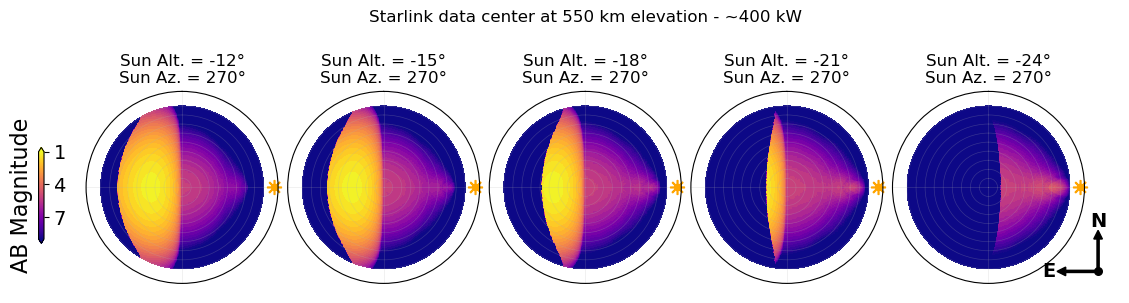

2.439720080203638
2.4342376375555776
2.439958089043855
2.4575651692689595
2.487410267892664


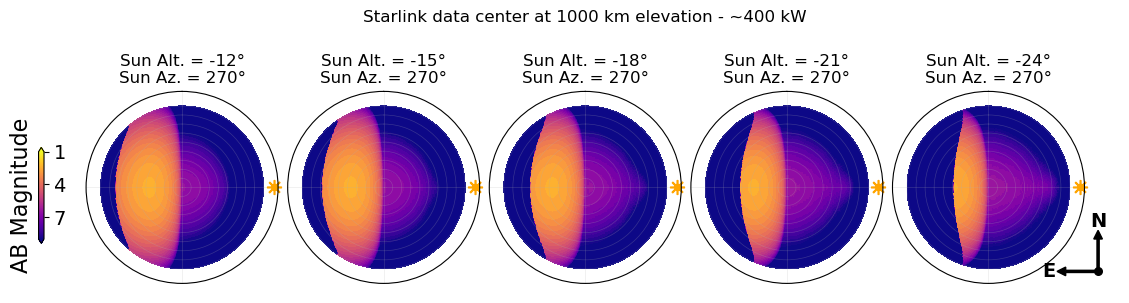

3.3470322463452624
3.352322201570339
3.3702329862100133
3.4004042617745327
3.4403150675651304


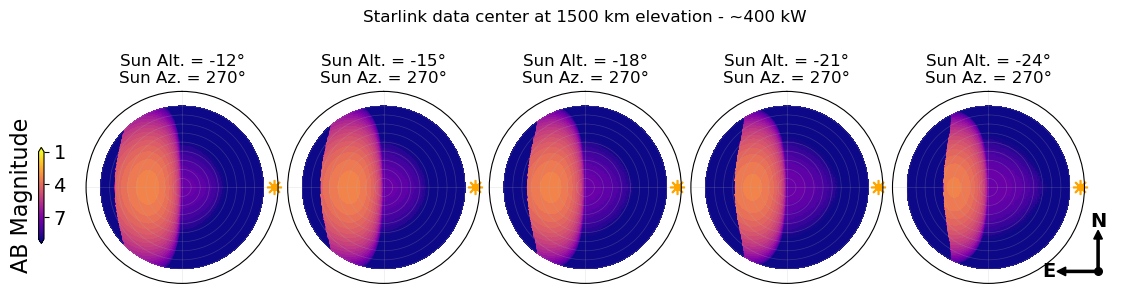

4.007108422850375
4.024331925735905
4.053650243894068
4.091651905599807
4.141568671393841


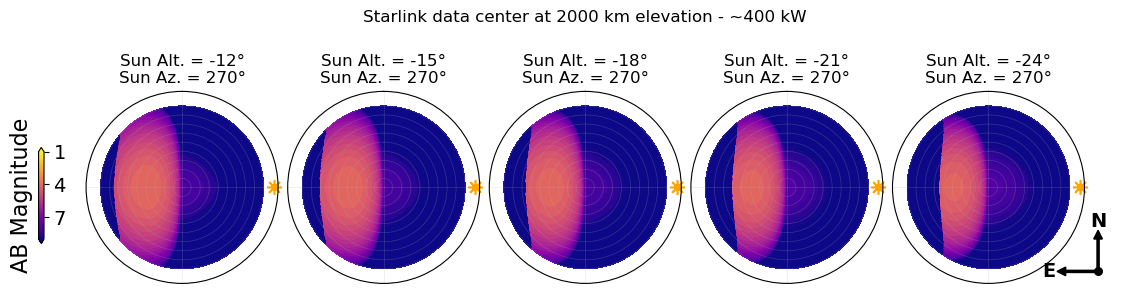

In [4]:
# Define solar array areas and their power equivalents
solar_array_configs_continuous = [
    (104.96 * 16, "~400 kW")
]

sat_height = [550.0, 1000, 1500, 2000] # in Km

# Loop through each solar array configuration
for area, power_label in solar_array_configs_continuous:
    # Set up the satellite model surfaces with current solar array area
    surfaces = satellitemodels.get_surfaces()
    solar_array_surface = Surface(area, [0, 1, 0], lab_solar_array_brdf)
    surfaces.append(solar_array_surface)
    
    print(f"\nGenerating plots for {power_label} (Area: {area:.2f} m²)")
    
    # Generate plots for each satellite height
    for h in sat_height:
        brightness_summary_observer_frame(
            h * 1000,
            [-12, -15, -18, -21, -24],
            [270., 270., 270., 270., 270.],
            levels=(1, 9),
            include_sun=True,
            include_earthshine=False,
            name=f"Starlink data center at {h:.0f} km elevation - {power_label}"
        )